In [11]:
import numpy as np
import h5py
import netCDF4
from glob import glob
import pandas as pd
import ipywidgets as widgets
import json
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
# Functions and variables
k = 1.38*10**(-23) # J/K
def Ne_convert(e: float,P: float,T: float) -> float:
    return e*P/(k*T)

def z(p):
    return - 7 * np.log(p/1013.25)

def format_time(hours_float):
    hours = int(hours_float)
    minutes_float = (hours_float - hours) * 60
    minutes = int(minutes_float)
    formatted_time = f'{hours:02}:{minutes:02}:00Z'
    return formatted_time

time_save = np.arange(0,24,1) 
time_bin = time_save[1]
H_save = np.arange(90,130,4)
h_bin = H_save[1] - H_save[0]
bins = len(time_save) * len(H_save) 

In [3]:
data_folder_path = '../../DataSorted/*'
data_folders = glob(data_folder_path)
data_folders = sorted(data_folders)
print(len(data_folders), 'folders found.')

dst_index_path = '../../Index/DST_global.csv'
dst_index_file = pd.read_csv(dst_index_path)
print(len(dst_index_file), 'days founds.')

hp30_index_path = '../../Index/Hp30_global.json'
with open(hp30_index_path, 'r') as file:
    hp30_index_file = json.load(file)
    hp30_date = np.array(hp30_index_file['datetime'])
    hp30_index = np.array(hp30_index_file['Hp30'])
print(int(len(hp30_index_file['datetime'])/48), 'days founds.')

278 folders found.
1097 days founds.
1097 days founds.


In [4]:
folder_index = 1

exp_data_points = []
model_data_points = []

progress_bar = widgets.IntProgress(
    value=folder_index,
    min  = 0,
    max  = len(data_folders),
    description = 'Progress:',
    bar_style   = 'info',
    orientation = 'horizontal'
)
display(progress_bar)

# Iterating over folders
for folder in data_folders:
    # Glob path for each files
    EXP_path = folder + '/MAD*.hdf5'
    WACCM_path = folder + '/*.nc'

    WACCM_files = []

    if len(glob(WACCM_path)) > 1:
        for file in glob(WACCM_path):
            WACCM_files.append(netCDF4.Dataset(file))
    elif len(glob(WACCM_path)) == 1:
        WACCM_files = [netCDF4.Dataset(glob(WACCM_path)[0])]
    else:
        WACCM_files = []
        break

    # Iterating over all experiment file
    for file in glob(EXP_path): 
        EXP_file = h5py.File(file)
        
        data = EXP_file['Data']['Table Layout'][:] # Get data from the file
        metadata = EXP_file['Metadata']['Data Parameters'][:] # Get data parameters from the file
        parameters = [parameter[0] for parameter in metadata] # Get the name of each parameters

        data = np.array([np.array(tuple.tolist()) for tuple in data])
        dataframe = pd.DataFrame(data, columns=parameters)
    
        h_start = np.array(dataframe[b'GDALT']) # Start Altitude km
        h_end = np.array(dataframe[b'RANGE']) # END Altitude km
        Ne = np.array(dataframe[b'NE']) # Electron density m-3
        dNe = np.array(dataframe[b'DNE']) # Electron density error m-3
        Ti = np.array(dataframe[b"TI"]) # Ion temperature K
        Tr = np.array(dataframe[b'TR']) # Electron to ion temperature ratio
        hours = np.array(dataframe[b'HOUR']) # Hours
        minutes = np.array(dataframe[b'MIN']) # Minutes

        # Restrict experiment values to below 150 km
        h_mask = h_end < 150
        h_start = h_start[h_mask]
        h_end = h_end[h_mask]
        Ne = Ne[h_mask]
        dNe = dNe[h_mask]
        Ti = Ti[h_mask]
        Tr = Tr[h_mask]
        Te = Ti * Tr
        hours = hours[h_mask]
        minutes = minutes[h_mask]
        time = hours + minutes/60

        lat = WACCM_files[0]['instr_lat'][:] # Latitude of the instrument
        lon = WACCM_files[0]['instr_lon'][:] # Longitude of the instrument
        num = WACCM_files[0]['instr_num'][:] # Numerical identifier of the instrument
        date = WACCM_files[0]['obs_date'][:] # Observation date
        time_WACCM = WACCM_files[0]['obs_time'][:] # Observation time
        lev = WACCM_files[0]['lev'][:] # 88 levels
        e = WACCM_files[0]['e'][:] # Mixing ratio
        T = WACCM_files[0]['T'] [:]# Temperature

        for WACCM_file in WACCM_files[1:]:
            temp_lat = WACCM_file['instr_lat'][:] # Latitude of the instrument
            temp_lon = WACCM_file['instr_lon'][:] # Longitude of the instrument
            temp_num = WACCM_file['instr_num'][:] # Numerical identifier of the instrument
            temp_date = WACCM_file['obs_date'][:] # Observation date
            temp_time = WACCM_file['obs_time'][:] # Observation time
            temp_e = WACCM_file['e'][:] # Mixing ratio 
            temp_T = WACCM_file['T'][:] # Temperature

            # Concatenate all model values into their unique array
            lat = np.concatenate((lat, temp_lat))
            lon = np.concatenate((lon, temp_lon))
            num = np.concatenate((num, temp_num))
            date = np.concatenate((date, temp_date))
            time_WACCM = np.concatenate((time_WACCM, temp_time))
            e = np.concatenate((e, temp_e))
            T = np.concatenate((T, temp_T))
        
        # Date restriction
        EXP_date = int(dataframe[b'YEAR'][0]*10000 + dataframe[b'MONTH'][0]*100 + dataframe[b'DAY'][0])
        date_mask = date == EXP_date
        lat = lat[date_mask]
        lon = lon[date_mask]
        time_WACCM = time_WACCM[date_mask]
        e = e[date_mask]
        T = T[date_mask]

        # Coordinate restrictions for Tromsø and Svalbard
        mask_tromso = (lat > 69.5) & (lat < 69.7)
        mask_svalbard = (lat > 78.8) & (lat < 79.0)

        if 'uhf' in file: # Check if this is a Tromsø experiment
            mask_location = mask_tromso
        elif '42m' in file: # Check if this is a Svalbard experiment
            mask_location = mask_svalbard

        # Pressure restriction for model value, 0.01 approx 80 km
        lev_mask = lev < 0.01
        P = lev[lev_mask]
        H = z(P)
        NeWACCM = []
        for array in e[mask_location]:
            NeWACCM.append(array[lev_mask])
        NeWACCM = np.array(NeWACCM)

        hours = time_WACCM[mask_location]/3600
        T = T[mask_location]

        # Split folder path to get specifif event 
        date = folder.split('/')[-1]

        if 'GEO' in date and 'SOL' in date:
            date = date.replace('-GEO', '')
            date = date.replace('-SOL', '')
        elif 'GEO' in date and 'SOL' not in date:
            date = date.replace('-GEO', '')
        elif 'GEO' not in date and 'SOL' in date:
            date = date.replace('-SOL', '')
        
        # Iterating over all altitude slot 
        for height_slot in H_save:
            h_start_mask = (h_start - height_slot <= h_bin) & (h_start - height_slot > 0) 
            h_end_mask = (h_end - height_slot <= h_bin) & (h_end - height_slot > 0)
            h_mask_EXP = h_start_mask + h_end_mask
            h_mask_WACCM = (H - height_slot <= h_bin) & (H - height_slot > 0) 
            # Iterating over all time slot 
            for time_slot in time_save:
                t_mask_EXP = (time[h_mask_EXP] - time_slot <= time_bin) & (time[h_mask_EXP] - time_slot > 0) 
                t_mask_WACCM = (hours - time_slot <= 0.5) & (hours - time_slot > 0) 
                
                if sum(t_mask_EXP) == 0 or sum(t_mask_WACCM) == 0: 
                    pass
                else:
                    Ne2_EXP = np.mean(Ne[h_mask_EXP][t_mask_EXP])
                    dNe_EXP = np.sqrt(np.sum(dNe[h_mask_EXP][t_mask_EXP]**2))/len(dNe[h_mask_EXP][t_mask_EXP]) 
                    Ne2_WACCM_array = np.array([]) #
                    index = 0
                    for index in range(len(NeWACCM[t_mask_WACCM])): 
                        Ne_array = NeWACCM[t_mask_WACCM][index][h_mask_WACCM]
                        T_array = T[t_mask_WACCM][index][lev_mask][h_mask_WACCM]
                        Ne2_WACCM_array = np.concatenate((Ne2_WACCM_array, Ne_convert(Ne_array,P[h_mask_WACCM]*100,T_array))) 

                    exp_data_points.append(len(Ne[h_mask_EXP][t_mask_EXP]))
                    model_data_points.append(len(Ne2_WACCM_array))
    
    folder_index += 1
    progress_bar.value = folder_index

IntProgress(value=1, bar_style='info', description='Progress:', max=278)

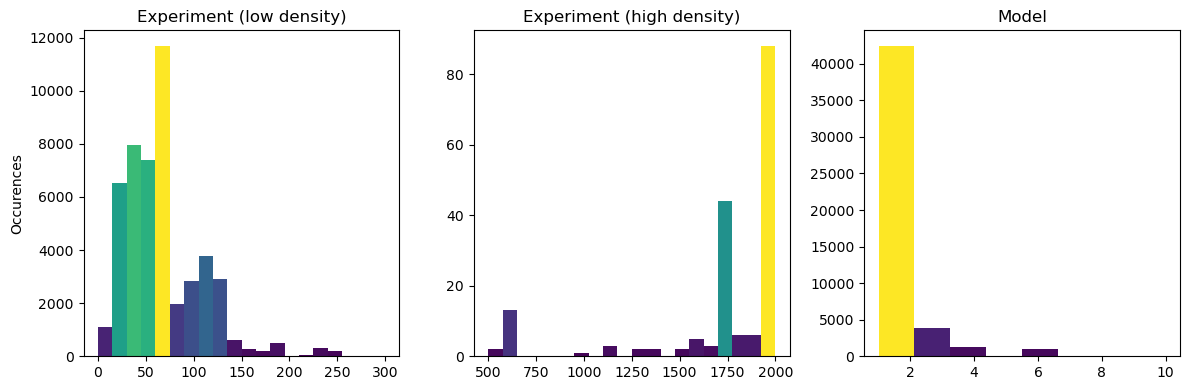

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

bins1 = np.linspace(0,300,21)
bins2 = np.linspace(1,10,9)
bins3 = np.linspace(500,2000,21)

N, bins, patches = axs[0].hist(exp_data_points, bins=bins1)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

N, bins, patches = axs[1].hist(exp_data_points, bins=bins3)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

N, bins, patches = axs[2].hist(model_data_points,  bins=bins2)
fracs = N / N.max()
norm = colors.Normalize(fracs.min(), fracs.max())
for thisfrac, thispatch in zip(fracs, patches):
    color = plt.cm.viridis(norm(thisfrac))
    thispatch.set_facecolor(color)

axs[0].set_title('Experiment (low density)')
axs[0].set_ylabel('Occurences')
axs[1].set_title('Experiment (high density)')
axs[2].set_title('Model')


plt.tight_layout()
#fig.suptitle('Data point repartition - 10 km-1 hour bin')
plt.savefig(f'../../Output/Figures/Data-Point-Repartition.png')
plt.show()

In [6]:
print(f'Experiment Data points: {sum(exp_data_points)}  -  Model Data Points: {sum(model_data_points)}')

unique_exp_dp, counts_exp = np.unique(exp_data_points, return_counts=True)
unique_model_dp, counts_model = np.unique(model_data_points, return_counts=True)

exp_dp_sum = []
model_dp_sum = []

for i in range(len(unique_exp_dp)):
    exp_dp_sum.append(np.sum(unique_exp_dp[:i+1] * counts_exp[0:i+1])/np.sum(exp_data_points))

for i in range(len(unique_model_dp)):
    model_dp_sum.append(np.sum(unique_model_dp[:i+1] * counts_model[0:i+1])/np.sum(model_data_points))

Experiment Data points: 3499922  -  Model Data Points: 76760


[90, 139, 240, 1892]
[2, 3, 4, 6]


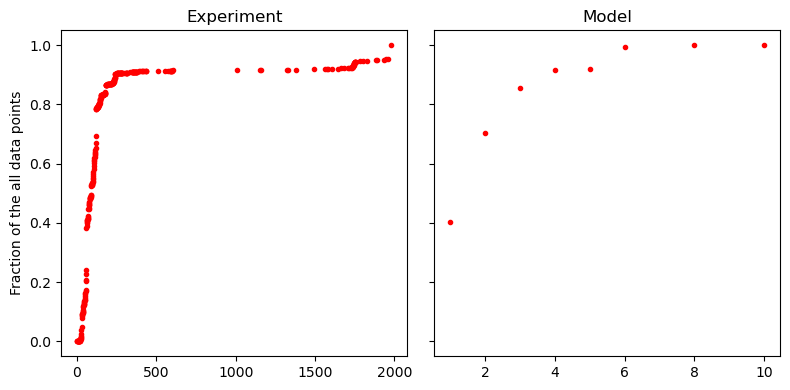

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True)

def find_percent(values, sum, percents):
    percents_return = []
    for percent in percents:
        percents_return.append(values[np.array(sum) > percent/100][0])
    return percents_return

print(find_percent(unique_exp_dp, exp_dp_sum, [50,80,90,95]))
print(find_percent(unique_model_dp, model_dp_sum, [50,80,90,95]))


axs[0].scatter(unique_exp_dp, exp_dp_sum,c='red', marker='.')
axs[0].set_ylabel('Fraction of the all data points')
axs[0].set_title('Experiment')
axs[1].scatter(unique_model_dp,model_dp_sum, label='Raw Data', c='red', marker='.')
axs[1].set_title('Model')

plt.tight_layout()
plt.savefig(f'../../Output/Figures/Data-Point-Sum.png')
plt.show()